In diesem Jupyternotebook wird es um einen Vergleich zwischen der Arealstatistik und dem WorldCover 2021 Datensatz gehen.


In [ ]:
# Change to your environment variables for PROJ and GDAL to ensure proper functioning of geospatial libraries.
import os
os.environ["PROJ_LIB"] = r"C:\Users\alexa\anaconda3\envs\WC\Library\share\proj"
os.environ["GDAL_DATA"] = r"C:\Users\alexa\anaconda3\envs\WC\Library\share\gdal"

# installieren von openpyxl, matplotlib, seaborn, scikit-learn falls noch nicht vorhanden
# pip install openpyxl
# pip install matplotlib
# pip install seaborn
# pip install scikit-learn


Arealstatistik Schweiz

In [32]:
import geopandas as gpd
from shapely.geometry import box

# Punktlayer laden
punkte_gdf = gpd.read_file("../../../data/analysis/arealstatistik/Arealstatistik_Zeitreihe.gpkg")

# # Prüfen, ob das Koordinatensystem Meter verwendet (EPSG:2056 für Schweiz)

def erstelle_quadrat(punkt, groesse=100):
    """
    Erstellt ein Quadrat ('Polygon') der angegebenen Größe (in Meter)
    um den Mittelpunkt eines Punktes.
    """
    x, y = punkt.x, punkt.y
    halb = groesse / 2
    return box(x - halb, y - halb, x + halb, y + halb)

# Quadrat-Geometrien für jeden Punkt erzeugen (100x100 m um Mittelpunkt)
punkte_gdf["geometry"] = punkte_gdf.geometry.apply(lambda p: erstelle_quadrat(p, groesse=100))

# Optional: als neuen Polygon-Layer speichern
punkte_gdf.to_file("../../../data/analysis/arealstatistik/arealstatistik_grid_100m.gpkg", driver="GPKG")


Raster auf die gleiche Auflösung bringen nicht nötig, später löschen

In [ ]:
# import geopandas as gpd
# import rasterio
# from rasterio.mask import mask

# # Paths
# raster_path = "../../../data/preprocessing/worldcover/worldcover_2021_clipped.tif"
# mask_path = "../../../data/analysis/arealstatistik/arealstatistik_grid_100m.gpkg"

# # Read buffered border
# mask_gdf = gpd.read_file(mask_path)
# print(mask_gdf.crs)

EPSG:2056


In [ ]:
# mask_geom = [mask_gdf.union_all()]  # Combine if multiple polygons

In [ ]:
# with rasterio.open(raster_path) as src:
#     clipped_array, clipped_transform = mask(
#         dataset=src,
#         shapes=mask_geom,
#         crop=True,
#         nodata=0
#     )
#     clipped_meta = src.meta.copy()

# clipped_meta.update({
#     "driver": "GTiff",
#     "height": clipped_array.shape[1],
#     "width": clipped_array.shape[2],
#     "transform": clipped_transform,
# })

NameError: name 'rasterio' is not defined

Raster speichern

In [ ]:
# out_path = "../../../data/analysis/worldcover/worldcover_2021_clipped.tif"
# with rasterio.open(out_path, "w", **clipped_meta) as dest:
#     dest.write(clipped_array)

NameError: name 'rasterio' is not defined

Raster werte den Polygonen zuordnen (häufigste Klasse pro Polygon)

In [1]:
import geopandas as gpd
from rasterstats import zonal_stats
import numpy as np
import pandas as pd

# Pfad zum Raster
worldcover_raster = "../../../data/preprocessing/worldcover/worldcover_2021_clipped.tif"

# Polygonlayer laden
polygons = gpd.read_file("../../../data/analysis/arealstatistik/arealstatistik_grid_100m.gpkg")



# Zonal stats für Kategorien zählen (alle Rasterzellen zählen)
stats = zonal_stats(
    polygons,
    worldcover_raster,
    categorical=True,
    all_touched=True,
    nodata=0,
    geojson_out=False
)

# Für alle Polygone
klass_1 = []
klass_1_p = []
klass_2 = []
klass_2_p = []
klass_3 = []
klass_3_p = []

for stat in stats:
    # Anzahl Zellen pro Klasse, sortieren absteigend
    if not stat:
        # Falls kein Wert (leeres Polygon)
        klass_1.append(-1)
        klass_1_p.append(0)
        klass_2.append(-1)
        klass_2_p.append(0)
        klass_3.append(-1)
        klass_3_p.append(0)
        continue

    gesamt = sum(stat.values())
    sorted_klassen = sorted(stat.items(), key=lambda x: x[1], reverse=True)

    # Top 1
    klass_1.append(sorted_klassen[0][0])
    klass_1_p.append(sorted_klassen[0][1] / gesamt * 100)

    # Top 2 (falls vorhanden)
    if len(sorted_klassen) > 1:
        klass_2.append(sorted_klassen[1][0])
        klass_2_p.append(sorted_klassen[1][1] / gesamt * 100)
    else:
        klass_2.append(-1)
        klass_2_p.append(0)

    # Top 3 (falls vorhanden)
    if len(sorted_klassen) > 2:
        klass_3.append(sorted_klassen[2][0])
        klass_3_p.append(sorted_klassen[2][1] / gesamt * 100)
    else:
        klass_3.append(-1)
        klass_3_p.append(0)

# Neue Spalten hinzufügen
polygons["WorldCover_2021_class_1"] = klass_1
polygons["WorldCover_2021_class_1_Percent"] = klass_1_p
polygons["WorldCover_2021_class_2"] = klass_2
polygons["WorldCover_2021_class_2_Percent"] = klass_2_p
polygons["WorldCover_2021_class_3"] = klass_3
polygons["WorldCover_2021_class_3_Percent"] = klass_3_p

# Ergebnis speichern
polygons.to_file("../../../data/analysis/worldcover/arealstatistik_grid_100m_with_wc_top3.gpkg", driver="GPKG")


KeyboardInterrupt: 

Testing von paralleliserung

In [1]:
import geopandas as gpd
from rasterstats import zonal_stats
import numpy as np
import os
import gc  # Garbage Collector

# Pfad zu Raster und Polygonlayer
worldcover_raster = "../../../data/preprocessing/worldcover/worldcover_2020_clipped.tif"
polygons = gpd.read_file("../../../data/analysis/arealstatistik/arealstatistik_grid_100m.gpkg")

# Chunk-Größe für RAM schonende Verarbeitung
chunk_size = 200000
n = len(polygons)
output_dir = "../../../data/analysis/worldcover/chunks/"
os.makedirs(output_dir, exist_ok=True)

for i in range(0, n, chunk_size):
    print(f"Bearbeite Chunk {i//chunk_size+1} ({i} bis {min(i+chunk_size, n)} von {n}) ...")
    test_chunk = polygons.iloc[i:i+chunk_size].copy()

    stats = zonal_stats(
        test_chunk,
        worldcover_raster,
        categorical=True,
        all_touched=True,
        nodata=0,
        geojson_out=False,
        n_jobs=-1        # Parallelisiert auf alle verfügbare Kerne
    )

    klass_1, klass_1_p = [], []
    klass_2, klass_2_p = [], []
    klass_3, klass_3_p = [], []

    for stat in stats:
        if not stat:
            klass_1.append(-1)
            klass_1_p.append(0)
            klass_2.append(-1)
            klass_2_p.append(0)
            klass_3.append(-1)
            klass_3_p.append(0)
            continue
        gesamt = sum(stat.values())
        sorted_klassen = sorted(stat.items(), key=lambda x: x[1], reverse=True)
        klass_1.append(sorted_klassen[0][0])
        klass_1_p.append(sorted_klassen[0][1] / gesamt * 100)
        if len(sorted_klassen) > 1:
            klass_2.append(sorted_klassen[1][0])
            klass_2_p.append(sorted_klassen[1][1] / gesamt * 100)
        else:
            klass_2.append(-1)
            klass_2_p.append(0)
        if len(sorted_klassen) > 2:
            klass_3.append(sorted_klassen[2][0])
            klass_3_p.append(sorted_klassen[2][1] / gesamt * 100)
        else:
            klass_3.append(-1)
            klass_3_p.append(0)

    # Ergebnisse zum Chunk hinzufügen
    test_chunk["WorldCover_2020_class_1"] = klass_1
    test_chunk["WorldCover_2020_class_1_Percent"] = klass_1_p
    test_chunk["WorldCover_2020_class_2"] = klass_2
    test_chunk["WorldCover_2020_class_2_Percent"] = klass_2_p
    test_chunk["WorldCover_2020_class_3"] = klass_3
    test_chunk["WorldCover_2020_class_3_Percent"] = klass_3_p

    # Chunk einzeln abspeichern
    out_path = os.path.join(output_dir, f"chunk_{i//chunk_size:03d}.gpkg")
    test_chunk.to_file(out_path, driver="GPKG")
    print(f"Chunk gespeichert: {out_path}")

    # Speicher nach jedem Chunk freigeben
    del test_chunk, stats, klass_1, klass_1_p, klass_2, klass_2_p, klass_3, klass_3_p
    gc.collect()

# OPTIONAL nach der gesamten Schleife: Auch Ursprungsobjekt löschen
del polygons
gc.collect()


Bearbeite Chunk 1 (0 bis 200000 von 4129071) ...
Chunk gespeichert: ../../../data/analysis/worldcover/chunks/chunk_000.gpkg
Bearbeite Chunk 2 (200000 bis 400000 von 4129071) ...
Chunk gespeichert: ../../../data/analysis/worldcover/chunks/chunk_001.gpkg
Bearbeite Chunk 3 (400000 bis 600000 von 4129071) ...
Chunk gespeichert: ../../../data/analysis/worldcover/chunks/chunk_002.gpkg
Bearbeite Chunk 4 (600000 bis 800000 von 4129071) ...
Chunk gespeichert: ../../../data/analysis/worldcover/chunks/chunk_003.gpkg
Bearbeite Chunk 5 (800000 bis 1000000 von 4129071) ...
Chunk gespeichert: ../../../data/analysis/worldcover/chunks/chunk_004.gpkg
Bearbeite Chunk 6 (1000000 bis 1200000 von 4129071) ...
Chunk gespeichert: ../../../data/analysis/worldcover/chunks/chunk_005.gpkg
Bearbeite Chunk 7 (1200000 bis 1400000 von 4129071) ...
Chunk gespeichert: ../../../data/analysis/worldcover/chunks/chunk_006.gpkg
Bearbeite Chunk 8 (1400000 bis 1600000 von 4129071) ...
Chunk gespeichert: ../../../data/analysis

0

zusammensetzen der einzelnen chunks

In [2]:
import geopandas as gpd
import pandas as pd
import glob
import os

# Chunk-Verzeichnis und Suchmaske definieren
chunk_dir = "../../../data/analysis/worldcover/chunks/"
chunk_files = sorted(glob.glob(os.path.join(chunk_dir, "chunk_*.gpkg")))

# Alle Chunks einlesen und zu einer GeoDataFrame zusammenfügen
chunks = []
for f in chunk_files:
    print(f"Lade {f} ...")
    gdf = gpd.read_file(f)
    chunks.append(gdf)

full_gdf = gpd.GeoDataFrame(pd.concat(chunks, ignore_index=True), crs=chunks[0].crs)

# Endergebnis abspeichern
full_gdf.to_file("../../../data/analysis/worldcover/arealstatistik_grid_100m_with_wc_top3_2020.gpkg", driver="GPKG")
print("Finaler Layer gespeichert!")


Lade ../../../data/analysis/worldcover/chunks\chunk_000.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_001.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_002.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_003.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_004.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_005.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_006.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_007.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_008.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_009.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_010.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_011.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_012.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_013.gpkg ...
Lade ../../../data/analysis/worldcover/chunks\chunk_014.gpkg ...
Lade ../../../data/analys

Arealstatistik Klassen den WorldCover Klassen zuordnen

In [1]:
import geopandas as gpd
import pandas as pd

# Arealstatistik-Daten laden
polygons = gpd.read_file("../../../data/analysis/worldcover/arealstatistik_grid_100m_with_wc_top3_2021.gpkg")

# Excel-Mappingtabelle laden
mapping_df = pd.read_excel("../../../data/analysis/worldcover/Mapping_AS_WC_v2.xlsx")

# Angenommen, die Excel-Datei hat zwei Spalten: "AS18_72" und "WorldCover_class"
# Erstelle ein Mapping-Dictionary
mapping_dict = dict(zip(mapping_df["AS18_72"], mapping_df["WorldCover_class"]))

# Neue Spalte mit WorldCover Klassen erstellen basierend auf der Zuordnung
polygons["AS_auf_WorldCover"] = polygons["AS18_72"].map(mapping_dict)

# Fehlende Werte mit -1 ersetzen, ohne inplace=True
polygons["AS_auf_WorldCover"] = polygons["AS_auf_WorldCover"].fillna(-1)


# Ergebnis speichern
polygons.to_file("../../../data/analysis/worldcover/arealstatistik_mapped_2021_v2.gpkg", driver="GPKG")


Confusion Matrix erstellen und auswerten

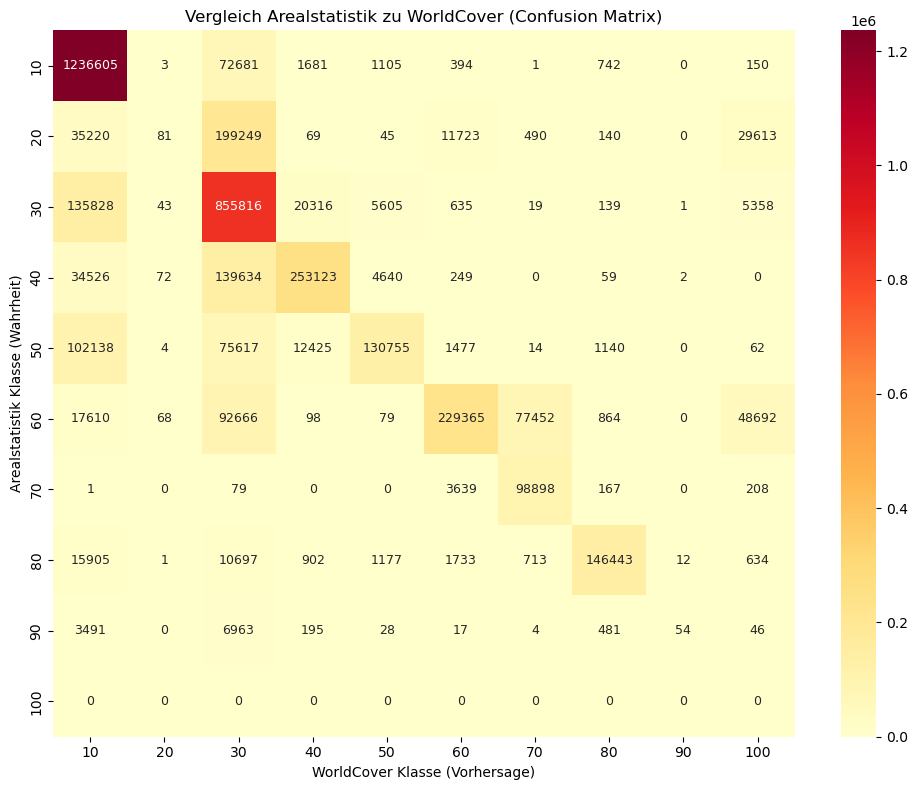

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# GeoDataFrame laden
df = gpd.read_file("../../../data/analysis/worldcover/arealstatistik_mapped_2021_v2.gpkg")

# Klassen vergleichen
y_true = df["AS_auf_WorldCover"]
y_pred = df["WorldCover_2021_class_1"]

# Alle Klassen bestimmen
labels = sorted(set(y_true).union(set(y_pred)))

# Confusion Matrix erstellen
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Größe und Schrift dynamisch anpassen
fig_width = max(10, len(labels) * 0.5)
fig_height = max(8, len(labels) * 0.5)

plt.figure(figsize=(fig_width, fig_height))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", 
            xticklabels=labels, yticklabels=labels,
            annot_kws={"size": 9})

plt.title("Vergleich Arealstatistik zu WorldCover (Confusion Matrix)")
plt.xlabel("WorldCover Klasse (Vorhersage)")
plt.ylabel("Arealstatistik Klasse (Wahrheit)")
plt.tight_layout()
plt.show()


Confusion Matrix erstellen zum verifizieren der Klassenzuordnung

In [5]:
import geopandas as gpd
import pandas as pd

# GeoDataFrame laden
df = gpd.read_file("../../../data/analysis/worldcover/arealstatistik_mapped_2021.gpkg")

# Kreuztabelle erstellen:
crosstab = pd.crosstab(
    df["AS18_72"],                      # Zeilen: originale AS Klassen
    df["WorldCover_2021_class_1"],      # Spalten: WorldCover Klassen
    rownames=["AS18_72"],               # Deutsche Achsen-Beschriftungen
    colnames=["WorldCover_2021_class_1"]
)

# Tabelle zeigen/prüfen
print(crosstab)

# Optional: Als Excel oder CSV abspeichern
crosstab.to_csv("../../../data/analysis/worldcover/AS_WC_kreuztabelle_2021.csv")
crosstab.to_excel("../../../data/analysis/worldcover/AS_WC_kreuztabelle_2021.xlsx")


WorldCover_2021_class_1    10   20     30   40     50      60     70   80   \
AS18_72                                                                      
1                          402    0    256   30   8596       4      0    5   
2                         1522    0    992  191  13433      87      0   20   
3                         6307    0   2429  135   5797       0      0   18   
4                        30626    1  11771  842  18606       0      0  170   
5                          586    0     46    4    778       0      0    0   
...                        ...  ...    ...  ...    ...     ...    ...  ...   
68                         245    0    551    0      1     262    101    0   
69                        9701   21  46425    5     38  107978  27071  400   
70                        6596   47  44062    4     28  121038  50279  458   
71                         178    0    496   89     11       4      0    6   
72                           1    0     79    0      0    3639  